<a href="https://colab.research.google.com/github/raigit/ML_GNN_PRACTICE/blob/master/Graph_Attention_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instead of calculating static weights based on node degrees like Graph Convolutional Networks(GCNs)
# They assign dynamic weights to node features through a process called self-attention
# The main idea behind GATs is that some neighbors are more important than others, regardless of their node degrees

In [5]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import numpy as np
np.random.seed(0)

import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 5.8 MB/s eta 0:00:00


In [ ]:
# 1. Graph data

In [9]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root = '.', name = 'CiteSeer')
data = dataset[0]

print(f'Number of graphs : {len(dataset)}')
print(f'Number of nodes : {data.x.shape[0]}')
print(f'Number of features : {dataset.num_features}')
print(f'Number of classes : {dataset.num_classes}')
print(f'Has isolated nodes : {data.has_isolated_nodes()}')
# this isolated nodes will be a challenge since we cannot rely on any aggregation
# this is how an MLP processes nodes L it cannot consider the adjacency matrix, which decreases its accuracy

Processing...


Number of graphs : 1
Number of nodes : 3327
Number of features : 3703
Number of classes : 6
Has isolated nodes : True


Done!


In [ ]:
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

<BarContainer object of 32 artists>

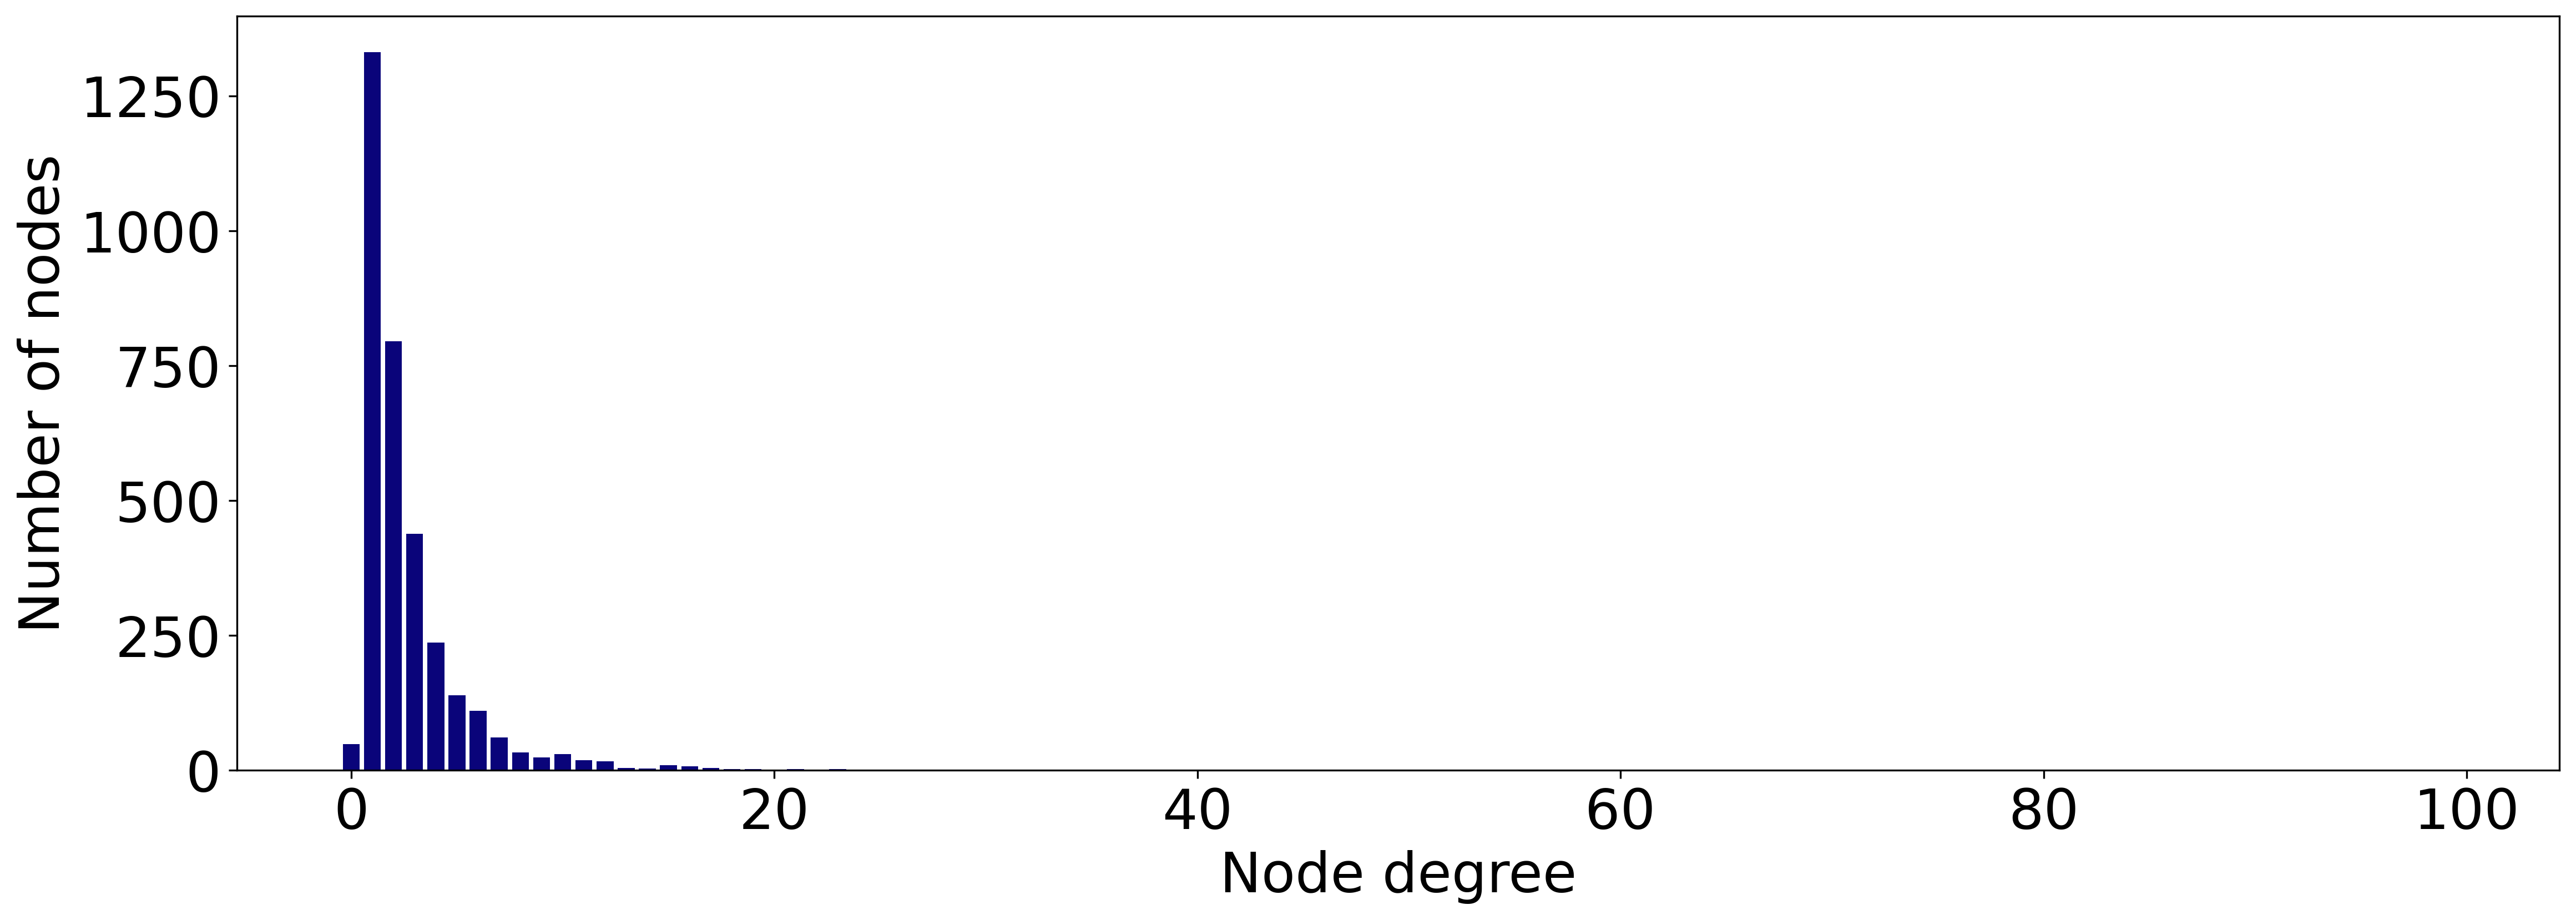

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)
# Node degree란 노드에 연결된 엣지 수의 합을 말한다.
# 즉 노드가 몇 개의 이웃을 가지는 지를 표현한 것이라 할 수 있다.

fig, ax = plt.subplots(figsize=(18, 6))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [ ]:
# 2. Graph Attention Layer

In [ ]:
# Self attention in GATs relies on a simple idea
# some nodes are more important than others

# self-attention calculates the importance of nodes
# and we denote aij the importance of node j's features to node i

# Each node i has an attribute vector xi
# The GAT layer calculates the embedding of node 1 as s um of attention coefficients multiplied by a shared weight matrix W
# hi = a11Wx1 + a12Wx2 + a13Wx3 + a14Wx4
# how can we calculate attention coefficients?
# there are four steps in his process

In [ ]:
# 2-1. Linear transformation

# to calculate the attention coefficient, we need to consider pairs of nodes
# an easy way to create these pairs is to concatenate attribute vectors from both nodes
 # then we can apply a new linear transformation with a weight matrix Watt

In [ ]:
# 2-2. Activation function

# Second step is to add nonlinearity with an activation function
# In this case, the paper's authors chose the LeakyReLU function
# eij = LeakyReLU(aij)

In [ ]:
# 2-3. Softmax normalization

# the output of our neural network is not normalized, which is a problem since we want to compare these coefficients
# For example to be able to say if node 2 is more important to node 1 than node 3 we need to use the same scale
# A common way to do it with neural networks is to use the softmax function
# aij = softmaxj(eij)

In [ ]:
# 2-4. Multi-head attention

# In GATs, multi-head attention consists of replicating the same three steps everal times in order to average or concatenate the results
# instead of a single embedding h1, we get one embedding per attention head
# in practice, use concatenation scheme when it's a hidden layer
# average scheme when it's the last layer

In [30]:
# 3. Implementing a Graph Attention Network

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATv2Conv

class GCN(nn.Module):

  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = optim.Adam(self.parameters(), lr = 0.01, weight_decay = 5e-4)
  
  def forward(self, x, edge_index):
    h = F.dropout(x, p = 0.5, training = self.training)
    h = self.gcn1(h, edge_index).relu()
    h = F.dropout(h, p = 0.5, training = self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim = 1)

class GAT(nn.Module):
    
  def __init__(self, dim_in, dim_h, dim_out, heads = 8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads = heads)
    self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads = 1)
    self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.005, weight_decay = 5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p = 0.6, training = self.training)
    h = self.gat1(h, edge_index).relu()
    h = F.dropout(h, p = 0.6, training = self.training)
    h = self.gat2(h, edge_index)
  
    return h, F.log_softmax(h, dim = 1)
  
def accuracy(pred_y, y):
  return ((pred_y) == y).sum() / len(y)

In [31]:
def train(model, data):
  crit = nn.CrossEntropyLoss()
  optimizer = model.optimizer
  epochs = 200
  
  model.train()
  for epoch in range(epochs + 1):
    optimizer.zero_grad()
    _, out = model(data.x, data.edge_index)
    loss = crit(out[data.train_mask], data.y[data.train_mask])
    acc = accuracy(out[data.train_mask].argmax(dim = 1), data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    val_loss = crit(out[data.val_mask], data.y[data.val_mask])
    val_acc = accuracy(out[data.val_mask].argmax(dim = 1), data.y[data.val_mask])

    if(epoch % 10 == 0):
      print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
    
  return model

@torch.no_grad()
def test(model, data):
  model.eval()
  _, out = model(data.x, data.edge_index)
  acc = accuracy(out[data.test_mask].argmax(dim = 1), data.y[data.test_mask])
  return acc

In [22]:
%%time

gcn = GCN(data.num_features, 16, dataset.num_classes)
print(gcn)

train(gcn, data)
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.788 | Train Acc:  15.00% | Val Loss: 1.80 | Val Acc: 15.40%
Epoch  10 | Train Loss: 0.566 | Train Acc:  86.67% | Val Loss: 1.34 | Val Acc: 53.40%
Epoch  20 | Train Loss: 0.246 | Train Acc:  95.00% | Val Loss: 1.32 | Val Acc: 59.40%
Epoch  30 | Train Loss: 0.138 | Train Acc:  97.50% | Val Loss: 1.52 | Val Acc: 56.80%
Epoch  40 | Train Loss: 0.087 | Train Acc:  98.33% | Val Loss: 1.51 | Val Acc: 58.40%
Epoch  50 | Train Loss: 0.065 | Train Acc:  99.17% | Val Loss: 1.58 | Val Acc: 59.20%
Epoch  60 | Train Loss: 0.048 | Train Acc:  99.17% | Val Loss: 1.53 | Val Acc: 58.60%
Epoch  70 | Train Loss: 0.053 | Train Acc: 100.00% | Val Loss: 1.57 | Val Acc: 59.80%
Epoch  80 | Train Loss: 0.043 | Train Acc: 100.00% | Val Loss: 1.55 | Val Acc: 58.60%
Epoch  90 | Train Loss: 0.053 | Train Acc: 100.00% | Val Loss: 1.53 | Val Acc: 60.00%
Epoch 100 | Train Loss: 0.072 | Train Acc:  98.33% | Val Loss: 1.73 | Val Acc: 5

In [33]:
%%time

gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)
train(gat, data)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.791 | Train Acc:  23.33% | Val Loss: 1.76 | Val Acc: 22.80%
Epoch  10 | Train Loss: 0.495 | Train Acc:  90.00% | Val Loss: 1.16 | Val Acc: 62.20%
Epoch  20 | Train Loss: 0.138 | Train Acc:  96.67% | Val Loss: 1.30 | Val Acc: 57.20%
Epoch  30 | Train Loss: 0.073 | Train Acc:  98.33% | Val Loss: 1.41 | Val Acc: 58.00%
Epoch  40 | Train Loss: 0.031 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 60.40%
Epoch  50 | Train Loss: 0.053 | Train Acc:  98.33% | Val Loss: 1.50 | Val Acc: 58.20%
Epoch  60 | Train Loss: 0.035 | Train Acc:  99.17% | Val Loss: 1.55 | Val Acc: 58.20%
Epoch  70 | Train Loss: 0.038 | Train Acc:  99.17% | Val Loss: 1.55 | Val Acc: 56.80%
Epoch  80 | Train Loss: 0.024 | Train Acc: 100.00% | Val Loss: 1.50 | Val Acc: 58.00%
Epoch  90 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 1.53 | Val Acc: 58.80%
Epoch 100 | Train Loss: 0.011 | Train Acc: 100.00% | Val Lo